## Notebook contents:
1. Code to create a hierarchical subset of imagenet and analyse classes
2. Code for transforms of varying saturation, contrast and resolution. And, visualizing the transforms on images

## Imagenet hierarchical subset script + analysis

In [25]:
from scipy.stats import entropy
from nltk.corpus import wordnet as wn
import numpy as np
def get_wordnet_term_info(term, pos_=None, hypo_depth =2 ):
    #returns list of tuples containing info for each synset mapped to term: [(synset, synset_def, synset example sentences, synset member holonym, hyper/further classes, hypo/parent classes)]
    base_synsets_noun = wn.synsets(term, pos =pos_)
    sense2freq = {}
    for s in base_synsets_noun:
        freq = 0  
        for lemma in s.lemmas():
            freq+=lemma.count()
        sense2freq[s.name()] = freq
    
    word_synsets_info = []
    num = 0 
    for bsyn in base_synsets_noun:
        word_synsets_info.append(get_synset_info(bsyn))
        num+=1
    word_synsets_info.insert(0,num)
    word_synsets_info.insert(1, sense2freq)
    ent = check_wordnet_sense_freq_distribution2(term)
    word_synsets_info.insert(2, ("Sense freq entropy",ent))
    return word_synsets_info

def get_synset_info(synset, hypo_depth=2):
    closure_lists_hyper = []
    closure_lists_hypo = []
    synset_info = []
    lemma_names = []
    hypo = lambda s: s.hyponyms()
    hyper = lambda s: s.hypernyms()
    synset_name = synset.name()
    syn_dict = {}
    syn_dict["name"] = synset_name
    syn_dict["synset"] = synset
    syn_dict["definition"] = synset.definition()
    syn_dict["lemma_names"] = synset.lemma_names()
    syn_dict["lexname"] = synset.lexname()
    syn_dict["examples"] = synset.examples()
    #syn_dict["member_holonyms"] = synset.member_holonyms()
    #syn_dict["hypernyms"] = list(synset.closure(hyper,))
    #syn_dict["hyponyms"] = list(synset.closure(hypo,depth = hypo_depth))
    #syn_dict["part_holonyms"] = synset.part_holonyms()
    #syn_dict["substance_holonyms"] = synset.substance_holonyms()
    #syn_dict["part_meronyms"] = synset.part_meronyms()
    #syn_dict["substance_meronyms"] = synset.substance_meronyms()
    syn_dict["tree"] = synset.tree(hyper)
    return syn_dict
    
    #return (synset, synset_name,synset.definition(), synset.lemma_names(), synset.examples(),synset.member_holonyms(), list(synset.closure(hyper,)),list(synset.closure(hypo,depth = hypo_depth)))

def get_closure_hypernyms_and_hyponyms_for_synset(term):
    closure_lists_hyper = []
    closure_lists_hypo = []
    hypo = lambda s: s.hyponyms()
    hyper = lambda s: s.hypernyms()
    base_synsets_noun = wn.synsets(term, pos =pos_)
    for bsyn in base_synsets_noun:
        closure_lists_hyper.append(list(bsyn.closure(hyper,)))
        closure_lists_hypo.append(list(bsyn.closure(hypo,depth = 2)))
    return closure_lists_hypo,closure_lists_hyper



def check_wordnet_sense_freq_distribution2(noun, thresh = 0.6, debug=False):
    #retrieve all senses ->  and distribution
    sense2freq = {}
    synsets = wn.synsets(noun, pos="n")
    freqs = []
    for s in synsets:
        freq = 0  
        for lemma in s.lemmas():
            freq+=lemma.count()
        sense2freq[s.name()] = freq
        freqs.append(freq)
        
    #measure entropy
    #print(sense2freq.values())
    #print(freqs)
    freqs_np = np.array(freqs)
    #freqs_normalized_np = freqs_np/sum(freqs_np)  
    ent = entropy(freqs_np)
    #ent_n = entropy(freqs_normalized_np)
    #print(freqs_normalized_np)
    #print(freqs)
    #print(ent,ent_n)
    #if entropy above a threshold, ask person to mark
    if(freqs_np.sum() == 0 and len(s)>1):
        ent = 1.0
    non_zeros = list(filter(lambda x:x>0, freqs_np))
    ent_non_zeros = entropy(non_zeros)
    #if(ent_non_zeros)
    
    return ent
    #if(ent>thresh):
        #print(ent, "Not sure which sense")
        #print(noun, sense2freq, ent)
     #   return -1 
    #else:
     #   if(debug):
      #      print(noun, sense2freq, ent)
       # return 0

###Heuristic 1: Choose both trees if similarity is high 0.55(for a class-> choose highest similarity tree for class representative), if not true, raise flag to user
###Heuristic 2: Between classes -> dominance (if diff. more than 2.5 of original class and 1st_freq>20 just take it -> else raise flag; 

def recur_wordnet_tree_path(remaining_path):
    if(len(remaining_path) == 1):
        if(remaining_path[0].name()!='entity.n.01'):
            print("ERROR")
        #print(remaining_path)
        #for possible_paths in paths_traversed:
         #   possible_paths.append([remaining_path[0]])
        return [[remaining_path]] 
    
    elif(len(remaining_path) == 2):
        #for possible_paths in paths_traversed:
         #   possible_paths.append([remaining_path[0]])
        paths_to_terminal = recur_wordnet_tree_path(remaining_path[1])
        #print("satat", paths_to_terminal)
        paths_to_terminal_appended = []
        for paths in paths_to_terminal:
            temp_path = [[remaining_path[0]]]+ paths
            paths_to_terminal_appended.append(temp_path)
            #path.insert(0,[remaining_path[0]])
        return paths_to_terminal_appended
    #    possible_paths.append(recur_wordnet_tree_path(paths_traversed, remaining_path[1])
    
    elif(len(remaining_path)>2):
        paths_to_terminal = [] #this is now different for each
        for path_cut in remaining_path[1:]:
            possible_path_to_terminal = recur_wordnet_tree_path(path_cut)
            for paths in possible_path_to_terminal:
                temp_path = [[remaining_path[0]]] + paths
                paths_to_terminal.append(temp_path)
        return paths_to_terminal
        #for path_cut in remaining_path[1:]: 
            #print(path_cut)
         #   possible_path_to_terminal = recur_wordnet_tree_path(path_cut)
          #  print(possible_path_to_terminal)
           # possible_path_to_terminal.insert(0,[remaining_path[0]])
            #paths_to_terminal.append(possible_path_to_terminal)
            #print(possible_path_to_terminal)
        return paths_to_terminal
        #new_paths_traversed = []    
        #for (possible_remaining_paths in remaining_path[1:]):
         #   new_paths_traversed = possible_paths.extend(recur_wordnet_tree_path(paths_traversed, possible_remaining_paths))
            
        #return recur_wordnet_tree_path(paths_traversed,remaining)
        
def check_tree_match(syn1, syn2, tree_sim):
    hyper = lambda x:x.hypernyms()
    formatted_trees = []
    chosen_synsets = [syn1,syn2]
    for synset in chosen_synsets:
        syn_tree = synset.tree(hyper) #s.append()
        formatted_tree = recur_wordnet_tree_path(syn_tree)
        formatted_trees.extend(formatted_tree)
    return simple_tree_agreement(formatted_trees, tree_sim)
    
def simple_tree_agreement(entity_tree_struct, agreement_cut =0.5):
    #Compute similarity between each -> nC2 similarities
    simpler_trees = []
    for possible_tree in entity_tree_struct:
        simpler_tree = list(map(lambda x:x[0], possible_tree))
        simpler_trees.append(simpler_tree)
        
    sim_matrix = []
    #simply check if agreement between each tree is more than 0.5 else raise flag
    for t1 in simpler_trees:
        for t2 in simpler_trees:
            st1 = set(t1)
            st2 = set(t2)
            common_elements = st1.intersection(st2)
            avg_len = (len(st1)+len(st2))/2
            similarity = len(common_elements)/avg_len
            #print(similarity)
            if(similarity<agreement_cut):
                return False
            ###  OR if the first 4 elements agree then use 
            
            #if(len(simpler_trees)==2):
             #   if(similarity>)
    return True

"""
def check_shared_trees_against_entities(list_of_tree_structs):
    None
def check_shared_trees_within_entity(entity_tree_struct):
    ## Input: [tree_structure_of_entity1,tree_structure_of_entity2,...]
    simpler_trees = []
    for possible_tree in entity_tree_struct:
        simpler_tree = list(map(lambda x:x[0], possible_tree))
        simpler_trees.append(simpler_tree)
"""        
    
    
#assumption_log = []    
def map_all_tree(trees):
    trees_2 = []
    for tree in trees:
        trees_2.append(list(map(lambda x: [x[0].name()], tree)))
    return trees_2

In [2]:
classes_ids_sen.split('\n')[0].split(' ')[-1].split('\t')[0]

In [3]:
classes_ids_f = [class_sen.split(' ')[-1].split('\t')[0] for class_sen in classes_ids_sen.split('\n')][:-1]

In [4]:
import numpy as np
import random 

In [5]:
from nltk.corpus import wordnet as wn

In [29]:
len(get_synset_info(wn.synset_from_pos_and_offset('n',int(classes_ids_f[-501][1:])))['tree'])

2

In [44]:
for i, syns in enumerate(tree[::-1]):
    print(syns[0])

Synset('cyprinid.n.01')


TypeError: 'Synset' object does not support indexing

In [143]:
syn = wn.synset_from_pos_and_offset('n',int(classes_ids_f[1][1:]))
tree = get_synset_info(syn)['tree']
recur_wordnet_tree_path(tree)[0][::-1]#[::-1]


[[Synset('entity.n.01')],
 [Synset('physical_entity.n.01')],
 [Synset('object.n.01')],
 [Synset('whole.n.02')],
 [Synset('living_thing.n.01')],
 [Synset('organism.n.01')],
 [Synset('animal.n.01')],
 [Synset('chordate.n.01')],
 [Synset('vertebrate.n.01')],
 [Synset('aquatic_vertebrate.n.01')],
 [Synset('fish.n.01')],
 [Synset('bony_fish.n.01')],
 [Synset('teleost_fish.n.01')],
 [Synset('soft-finned_fish.n.01')],
 [Synset('cypriniform_fish.n.01')],
 [Synset('cyprinid.n.01')],
 [Synset('goldfish.n.01')]]

In [62]:
wn_imnet_dict = {} #node: {children:{}}
imnet_wn_dict = {} #children: {node:{}}
for imnet_class in classes_ids_f:
    syn = wn.synset_from_pos_and_offset('n',int(imnet_class[1:]))
    trees = recur_wordnet_tree_path(get_synset_info(syn)['tree'])
    for tree in trees[:1]: #just taking first tree path for now
        tree_top_down = tree[::-1] #make tree starting with entity
        for i, tree_node in enumerate(tree_top_down):
            tree_node_syn = tree_node[0]
            if(i!=len(tree_top_down)-1):
                direct_children_synset = tree_top_down[i+1][0]
            else:
                direct_children_synset = None
            
            if(tree_node_syn not in wn_imnet_dict):
                wn_imnet_dict[tree_node_syn] ={'level':i, 
                                               'attached_imnet_classes':[imnet_class],
                                              'direct_children_synsets':[direct_children_synset],
                                              'attached_imnet_synsets':[syn]}
            else:
                wn_imnet_dict[tree_node_syn]['attached_imnet_classes'].append(imnet_class)
                wn_imnet_dict[tree_node_syn]['direct_children_synsets'].append(direct_children_synset),
                wn_imnet_dict[tree_node_syn]['attached_imnet_synsets'].append(syn)

            #for tree_nodes in tree:
        #if(tree_nodes[0] not in )
    #if(imnet_class not in wn_imnet_dict):
     #   wn_imnet_dict[]


In [65]:
wn_imnet_dict.items()

dict_items([(Synset('plant.n.01'), {'level': 7, 'attached_imnet_classes': ['n03697007'], 'attached_imnet_synsets': [Synset('lumbermill.n.01')], 'direct_children_synsets': [Synset('factory.n.01')]}), (Synset('thimble.n.02'), {'level': 8, 'attached_imnet_classes': ['n04423845'], 'attached_imnet_synsets': [Synset('thimble.n.02')], 'direct_children_synsets': [None]}), (Synset('bird_of_prey.n.01'), {'level': 10, 'attached_imnet_classes': ['n01608432', 'n01614925', 'n01616318', 'n01622779'], 'attached_imnet_synsets': [Synset('kite.n.04'), Synset('bald_eagle.n.01'), Synset('vulture.n.01'), Synset('great_grey_owl.n.01')], 'direct_children_synsets': [Synset('hawk.n.01'), Synset('eagle.n.01'), Synset('vulture.n.01'), Synset('owl.n.01')]}), (Synset('working_dog.n.01'), {'level': 14, 'attached_imnet_classes': ['n02104029', 'n02104365', 'n02105056', 'n02105162', 'n02105251', 'n02105412', 'n02105505', 'n02105641', 'n02105855', 'n02106030', 'n02106166', 'n02106382', 'n02106550', 'n02106662', 'n021071

In [63]:
wn_imnet_dict

{Synset('plant.n.01'): {'attached_imnet_classes': ['n03697007'],
  'attached_imnet_synsets': [Synset('lumbermill.n.01')],
  'direct_children_synsets': [Synset('factory.n.01')],
  'level': 7},
 Synset('thimble.n.02'): {'attached_imnet_classes': ['n04423845'],
  'attached_imnet_synsets': [Synset('thimble.n.02')],
  'direct_children_synsets': [None],
  'level': 8},
 Synset('bird_of_prey.n.01'): {'attached_imnet_classes': ['n01608432',
   'n01614925',
   'n01616318',
   'n01622779'],
  'attached_imnet_synsets': [Synset('kite.n.04'),
   Synset('bald_eagle.n.01'),
   Synset('vulture.n.01'),
   Synset('great_grey_owl.n.01')],
  'direct_children_synsets': [Synset('hawk.n.01'),
   Synset('eagle.n.01'),
   Synset('vulture.n.01'),
   Synset('owl.n.01')],
  'level': 10},
 Synset('working_dog.n.01'): {'attached_imnet_classes': ['n02104029',
   'n02104365',
   'n02105056',
   'n02105162',
   'n02105251',
   'n02105412',
   'n02105505',
   'n02105641',
   'n02105855',
   'n02106030',
   'n02106166',


In [113]:
import collections
ordered_by_level_wn_imnet_dict = collections.OrderedDict(sorted(wn_imnet_dict.items(), key = lambda x:x[1]['level']))            
level_keyed_dict = {} #level:[]
level_keyname_dict = {}
for key in wn_imnet_dict:
    level = wn_imnet_dict[key]['level']
    if(level not in level_keyed_dict):
        level_keyed_dict[level] = [wn_imnet_dict[key]]
        level_keyname_dict[level] = [key]
    else:
        level_keyed_dict[level].append(wn_imnet_dict[key])
        level_keyname_dict[level].append(key)

In [82]:
level_keyed_dict[1]

[{'attached_imnet_classes': ['n01440764',
   'n01443537',
   'n01484850',
   'n01491361',
   'n01494475',
   'n01496331',
   'n01498041',
   'n01514668',
   'n01514859',
   'n01518878',
   'n01530575',
   'n01531178',
   'n01532829',
   'n01534433',
   'n01537544',
   'n01558993',
   'n01560419',
   'n01580077',
   'n01582220',
   'n01592084',
   'n01601694',
   'n01608432',
   'n01614925',
   'n01616318',
   'n01622779',
   'n01629819',
   'n01630670',
   'n01631663',
   'n01632458',
   'n01632777',
   'n01641577',
   'n01644373',
   'n01644900',
   'n01664065',
   'n01665541',
   'n01667114',
   'n01667778',
   'n01669191',
   'n01675722',
   'n01677366',
   'n01682714',
   'n01685808',
   'n01687978',
   'n01688243',
   'n01689811',
   'n01692333',
   'n01693334',
   'n01694178',
   'n01695060',
   'n01697457',
   'n01698640',
   'n01704323',
   'n01728572',
   'n01728920',
   'n01729322',
   'n01729977',
   'n01734418',
   'n01735189',
   'n01737021',
   'n01739381',
   'n01740131'

In [128]:
level_keyname_dict[2]

[Synset('communication.n.02'),
 Synset('matter.n.03'),
 Synset('causal_agent.n.01'),
 Synset('attribute.n.02'),
 Synset('object.n.01')]

In [111]:
level_keyed_dict[1]#.keys()

[{'attached_imnet_classes': ['n01440764',
   'n01443537',
   'n01484850',
   'n01491361',
   'n01494475',
   'n01496331',
   'n01498041',
   'n01514668',
   'n01514859',
   'n01518878',
   'n01530575',
   'n01531178',
   'n01532829',
   'n01534433',
   'n01537544',
   'n01558993',
   'n01560419',
   'n01580077',
   'n01582220',
   'n01592084',
   'n01601694',
   'n01608432',
   'n01614925',
   'n01616318',
   'n01622779',
   'n01629819',
   'n01630670',
   'n01631663',
   'n01632458',
   'n01632777',
   'n01641577',
   'n01644373',
   'n01644900',
   'n01664065',
   'n01665541',
   'n01667114',
   'n01667778',
   'n01669191',
   'n01675722',
   'n01677366',
   'n01682714',
   'n01685808',
   'n01687978',
   'n01688243',
   'n01689811',
   'n01692333',
   'n01693334',
   'n01694178',
   'n01695060',
   'n01697457',
   'n01698640',
   'n01704323',
   'n01728572',
   'n01728920',
   'n01729322',
   'n01729977',
   'n01734418',
   'n01735189',
   'n01737021',
   'n01739381',
   'n01740131'

In [129]:
traversed_random_200_list = [] #select 2 at each level
ignore_levels = [0,1]
choice_at_each = 2
synset_class_to_hierarchical_labels = {}
##Basically at each level select
#ordered_by_level_wn_imnet_dict[wn.synset('entity.n.01')]['level']
exit_flag = False
for level in level_keyed_dict:
    print("At level:{}".format(level))
    if(level in ignore_levels):
        continue #Ignore entity level
    imnet_synsets_dicts = level_keyed_dict[level] 
    for synset_dict in imnet_synsets_dicts:
        attached_imnet_classes = synset_dict['attached_imnet_classes']
        #print(attached_imnet_classes)
        #attached_imnet_classes
        #selected_classes = random.sample(attached_imnet_classes,k=2)
        for i in range(choice_at_each):
            flag = False
            selected_class = random.sample(attached_imnet_classes,k=1)
            attempts = 0
            while(flag!=True):
                #print(attempts)
                attempts+=1
                if(attempts>5):
                    break
                if(selected_class not in traversed_random_200_list):
                    traversed_random_200_list.append(selected_class)
                    if(len(traversed_random_200_list)==200):
                        exit_flag=True
                        break
                else:
                    selected_class = random.sample(attached_imnet_classes,k=1)
            if(exit_flag):
                break
        if(exit_flag):
            break
    if(exit_flag):
        break

At level:0
At level:1
At level:2
At level:3
At level:4
At level:5
At level:6


In [130]:
traversed_random_200_list = [el[0] for el in traversed_random_200_list]

In [131]:
traversed_random_200_list

['n06794110',
 'n06874185',
 'n07875152',
 'n07730033',
 'n07892512',
 'n07584110',
 'n07880968',
 'n09835506',
 'n10148035',
 'n10565667',
 'n09229709',
 'n02979186',
 'n04209239',
 'n02097209',
 'n02859443',
 'n01735189',
 'n09193705',
 'n09256479',
 'n09399592',
 'n09332890',
 'n09468604',
 'n15075141',
 'n07860988',
 'n07873807',
 'n07932039',
 'n07613480',
 'n07717556',
 'n07714571',
 'n07716358',
 'n07716906',
 'n04125021',
 'n03160309',
 'n04235860',
 'n03126707',
 'n02701002',
 'n01685808',
 'n09288635',
 'n07684084',
 'n07695742',
 'n07693725',
 'n07711569',
 'n07753275',
 'n12620546',
 'n07753592',
 'n07747607',
 'n11879895',
 'n07920052',
 'n07583066',
 'n07615774',
 'n07831146',
 'n04254777',
 'n02988304',
 'n03866082',
 'n04081281',
 'n03876231',
 'n04493381',
 'n09246464',
 'n09428293',
 'n02167151',
 'n02085936',
 'n01847000',
 'n02085782',
 'n02526121',
 'n02105412',
 'n03124043',
 'n04417672',
 'n07248320',
 'n04507155',
 'n03424325',
 'n02895154',
 'n07565083',
 'n077

In [132]:
traversed_random_200_list_tuple_names = [(el, wn.synset_from_pos_and_offset('n',int(el[1:]))) for el in traversed_random_200_list]

In [133]:
traversed_random_200_list_tuple_names

[('n06794110', Synset('street_sign.n.01')),
 ('n06874185', Synset('traffic_light.n.01')),
 ('n07875152', Synset('potpie.n.01')),
 ('n07730033', Synset('cardoon.n.02')),
 ('n07892512', Synset('red_wine.n.01')),
 ('n07584110', Synset('consomme.n.01')),
 ('n07880968', Synset('burrito.n.01')),
 ('n09835506', Synset('ballplayer.n.01')),
 ('n10148035', Synset('groom.n.01')),
 ('n10565667', Synset('scuba_diver.n.01')),
 ('n09229709', Synset('bubble.n.01')),
 ('n02979186', Synset('cassette_player.n.01')),
 ('n04209239', Synset('shower_curtain.n.01')),
 ('n02097209', Synset('standard_schnauzer.n.01')),
 ('n02859443', Synset('boathouse.n.01')),
 ('n01735189', Synset('garter_snake.n.01')),
 ('n09193705', Synset('alp.n.01')),
 ('n09256479', Synset('coral_reef.n.01')),
 ('n09399592', Synset('promontory.n.01')),
 ('n09332890', Synset('lakeside.n.01')),
 ('n09468604', Synset('valley.n.01')),
 ('n15075141', Synset('toilet_tissue.n.01')),
 ('n07860988', Synset('dough.n.01')),
 ('n07873807', Synset('piz

In [ ]:
[0][::-1]

In [144]:
def get_hierarchical_labels(start_level=3,max_num_labels =5):
    ##Use the start level and max_num_labels for retrieval script
    #For now just output all the hierarchal synsets from entity till terminal 
    None
    
    

traversed_random_200_list_tuple_names_and_trees = [(el[0],el[1],recur_wordnet_tree_path(get_synset_info(el[1])['tree'])[0][::-1]) for el in traversed_random_200_list_tuple_names]

In [ ]:
traversed_random_200_list_tuple_trees = [(el[0],recur_wordnet_tree_path(get_synset_info(el[1])['tree'])[0][::-1]) for el in traversed_random_200_list_tuple_names]

In [146]:
traversed_random_200_list_tuple_names_and_trees

[('n06794110',
  Synset('street_sign.n.01'),
  [[Synset('entity.n.01')],
   [Synset('abstraction.n.06')],
   [Synset('communication.n.02')],
   [Synset('sign.n.02')],
   [Synset('street_sign.n.01')]]),
 ('n06874185',
  Synset('traffic_light.n.01'),
  [[Synset('entity.n.01')],
   [Synset('abstraction.n.06')],
   [Synset('communication.n.02')],
   [Synset('signal.n.01')],
   [Synset('visual_signal.n.01')],
   [Synset('light.n.14')],
   [Synset('traffic_light.n.01')]]),
 ('n07875152',
  Synset('potpie.n.01'),
  [[Synset('entity.n.01')],
   [Synset('physical_entity.n.01')],
   [Synset('matter.n.03')],
   [Synset('substance.n.07')],
   [Synset('food.n.01')],
   [Synset('nutriment.n.01')],
   [Synset('dish.n.02')],
   [Synset('potpie.n.01')]]),
 ('n07730033',
  Synset('cardoon.n.02'),
  [[Synset('entity.n.01')],
   [Synset('physical_entity.n.01')],
   [Synset('matter.n.03')],
   [Synset('solid.n.01')],
   [Synset('food.n.02')],
   [Synset('produce.n.01')],
   [Synset('vegetable.n.01')],
   [

In [152]:
import os, shutil
import pickle

In [166]:
path_for_200traversed = '/data/shantanu/Image_datasets/200_Imagenet_hierarchy_traversed/'
if(not os.path.exists(os.path.join(path_for_200traversed,"class_ids.txt"))):
    #os.makedirs(os.path.join(path_for_200random,"class_ids.txt"))
    with open("/data/shantanu/Image_datasets/200_Imagenet_hierarchy_traversed/class_ids.txt",'w') as f:
        for class_id in traversed_random_200_list:
            f.write('%s\n' % class_id)
            

    

In [33]:
import os

In [169]:
path_for_200random = '/data/shantanu/Image_datasets/200_Imagenet_hierarchy_traversed/'
original_imnet_dir = '/data/shantanu/Image_datasets/Imagenet/ImageNet2012-pre/images/'

In [170]:
if(not os.path.exists(os.path.join(path_for_200random,"train"))):
    os.makedirs(os.path.join(path_for_200random,"train"))
    path_for_200random_tr = os.path.join(path_for_200random,"train")
if(not os.path.exists(os.path.join(path_for_200random,"val_ptorch_format"))):
    os.makedirs(os.path.join(path_for_200random,"val_ptorch_format"))
    path_for_200random_val = os.path.join(path_for_200random,"val_ptorch_format")

In [171]:
os.listdir(path_for_200random)

['class_ids.txt',
 'train',
 'class_tuple_name_hierarchy.pkl',
 'val_ptorch_format']

In [172]:
original_imnet_tr = os.path.join(original_imnet_dir,'train')
original_imnet_val = os.path.join(original_imnet_dir,'val_ptorch_format')

In [642]:
os.listdir(os.path.join(os.path.join(original_imnet_dir,'train'),'n03201208' ))

['n03201208_4352.JPEG',
 'n03201208_15211.JPEG',
 'n03201208_32919.JPEG',
 'n03201208_14723.JPEG',
 'n03201208_9048.JPEG',
 'n03201208_19579.JPEG',
 'n03201208_3233.JPEG',
 'n03201208_30343.JPEG',
 'n03201208_28679.JPEG',
 'n03201208_24652.JPEG',
 'n03201208_16853.JPEG',
 'n03201208_14090.JPEG',
 'n03201208_3244.JPEG',
 'n03201208_61702.JPEG',
 'n03201208_28824.JPEG',
 'n03201208_14396.JPEG',
 'n03201208_9112.JPEG',
 'n03201208_21641.JPEG',
 'n03201208_27326.JPEG',
 'n03201208_28201.JPEG',
 'n03201208_7825.JPEG',
 'n03201208_10695.JPEG',
 'n03201208_20220.JPEG',
 'n03201208_23897.JPEG',
 'n03201208_5412.JPEG',
 'n03201208_43331.JPEG',
 'n03201208_27483.JPEG',
 'n03201208_20271.JPEG',
 'n03201208_26009.JPEG',
 'n03201208_25501.JPEG',
 'n03201208_2678.JPEG',
 'n03201208_12125.JPEG',
 'n03201208_32663.JPEG',
 'n03201208_4490.JPEG',
 'n03201208_7606.JPEG',
 'n03201208_1773.JPEG',
 'n03201208_7426.JPEG',
 'n03201208_13.JPEG',
 'n03201208_34717.JPEG',
 'n03201208_11028.JPEG',
 'n03201208_6.J

In [643]:
import shutil

In [173]:
for rand_selected_class in traversed_random_200_list:
    #if(not os.path.exists(os.path.join(path_for_200random_tr,rand_selected_class))):
        #os.makedirs(os.path.join(path_for_200random_tr,rand_selected_class))
    shutil.copytree(os.path.join(original_imnet_tr, rand_selected_class), os.path.join(path_for_200random_tr, rand_selected_class))
    shutil.copytree(os.path.join(original_imnet_val, rand_selected_class), os.path.join(path_for_200random_val, rand_selected_class))

### Calculating normalization values and transforms for varying color (optional)

In [2]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os
#import tensorflow as tf
from PIL import ImageStat

In [115]:
from torchvision.transforms import functional as F
class Lambda(object):
    """Apply a user-defined lambda as a transform.
    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + " object is not callable"
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
    
class ColorVary(object):
    """Randomly change the brightness, contrast and saturation of an image.
    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness #self._check_input(brightness, 'brightness')
        self.contrast = contrast#self._check_input(contrast, 'contrast')
        self.saturation = saturation#self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.
        Arguments are same as that of __init__.
        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []

        if brightness is not None:
            brightness_factor = brightness #brightnrandom.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if saturation is not None:
            saturation_factor = saturation#random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if contrast is not None:
            contrast_factor = contrast #random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        
        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        #random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Input image.
        Returns:
            PIL Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast, self.saturation, self.hue)
        return transform(img)

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        format_string += 'brightness={0}'.format(self.brightness)
        format_string += ', contrast={0}'.format(self.contrast)
        format_string += ', saturation={0}'.format(self.saturation)
        format_string += ', hue={0})'.format(self.hue)
        return format_string

In [133]:
traindir = os.path.join('/data/shantanu/Image_datasets/200_Imagenet_random/', 'val')
#valdir = os.path.join(args.data, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

or_train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
        ]))

In [267]:
import numbers


def get_normalization_values(train_dir, sat_val, con_val, res, interpolation_type=2):
    """Calculates normalization values for a sample of entire dataset"""
    print("Loading dataset train for sample normalization values")
    train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
            transforms.Resize(res+32, interpolation=interpolation_type),
            transforms.RandomCrop(res),
            ColorVary(1,con_val,sat_val,0),
            transforms.ToTensor(),
        ]))
    
    print("Calculating normalization values")
    batch_size=len(train_dataset)//1000 #256
    num_batches = len(train_dataset)//batch_size +1
    num_workers = 0
    max_n_sample_batches = 5
    data_loader = DataLoader(train_dataset,batch_size=batch_size, num_workers=num_workers, shuffle=True)#len(or_train_dataset))
    mean = 0.
    std = 0.
    nb_samples = 0
    time_start = time.clock()
    for i, (images, _) in enumerate(data_loader):
        if(i%10==0):
            print("at {} out of {}/({})".format(i, max_n_sample_batches, num_batches))
        
        if(i>max_n_sample_batches):
            break
    
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples+= batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    time_end = time.clock()
    print("Caclculated normalization values from samples", time_end-time_start)
    print(mean, std)  
    return mean, std

train_dir = os.path.join('/data/shantanu/Image_datasets/Imagenet/ImageNet2012-pre/images/', 'train')
val_dir = os.path.join('/data/shantanu/Image_datasets/Imagenet/ImageNet2012-pre/images/','val')
#valdir = os.path.join(args.data, 'val')
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
 #                                    std=[0.229, 0.224, 0.225])
use_normalization = True
sat_val = 0.8
con_val = 0.8
res = 128
interpolation_type = 2
use_data_augmentation = True



if(use_normalization in [0,'0']):
    #Calculate for a sample
    mean, std = get_normalization_values(train_dir)
    normalize = transforms.Normalize(mean= mean, std=std)
elif(use_normalization in [1,'1']):
    #Use default imagenet
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
elif(use_normalization in [-1,'-1']):
    #dont use
    normalize = None
elif(use_normalization in [2,'2']):
    print("Normalizing each input batch not done yet...exiting")
    sys.exit(0)
else:
    print("Wrong normalization terminal input...")
    

print("Preparing training dataloader")
if(use_data_augmentation):
    ##Currently only random horizontal flip
    if(res>=224 and 0): #CURRENTLY NOT USING THIS
        train_dataset = datasets.ImageFolder(
            train_dir,
            #transforms.Resiz([
            transforms.Compose([
            transforms.RandomResizedCrop(res,interpolation=interpolation_type),#, interpolation =interpolation_type),
            transforms.RandomHorizontalFlip(),
            ColorVary(1,con_val,sat_val,0),
            transforms.ToTensor(),
            normalize
        ]))
    elif(1):
        train_dataset = datasets.ImageFolder(
            train_dir,
            #transforms.Resiz([
            transforms.Compose([
            transforms.Resize(res+32, interpolation =interpolation_type),
            transforms.RandomCrop(res),
            transforms.RandomHorizontalFlip(),
            ColorVary(1,con_val,sat_val,0),
            transforms.ToTensor(),
            normalize
        ]))
else:
    train_dataset = datasets.ImageFolder(
            train_dir,
            transforms.Compose([
            transforms.Resize(res+32, interpolation =interpolation_type),
            transforms.RandomCrop(res),
            #transforms.RandomHorizontalFlip(),
            ColorVary(1,con_val,sat_val,0),
            transforms.ToTensor(),
            normalize
        ]))
    
if(res==224 and 0):
    val_dataset = datasets.ImageFolder(
            val_dir,
            transforms.Compose([
                transforms.Resize(256, interpolation =interpolation_type),
                transforms.CenterCrop(224),  #just to keep it in standard with other imagenet models
                ColorVary(1,con_val,sat_val,0),
                transforms.ToTensor(),
                normalize
            ]))
else:
    val_dataset = datasets.ImageFolder(
            val_dir,
            transforms.Compose([
                transforms.Resize(res+32, interpolation =interpolation_type),
                transforms.CenterCrop(res),
                ColorVary(1,con_val,sat_val,0),
                transforms.ToTensor(),
                normalize
            ]))


Preparing training dataloader


In [582]:
int(64*0.143)

9

In [579]:
32/224

0.14285714285714285

In [274]:
len(train_dataset)//1000 

1281

In [577]:
def get_normalization_values2(train_dir, sat_val, con_val, res, interpolation_type=2):
    """Calculates normalization values for a sample of entire dataset"""
    print("Loading dataset train for sample normalization values")
    train_dataset = datasets.ImageFolder(
        train_dir,
        transforms.Compose([
            transforms.Resize(res, interpolation=interpolation_type),
            transforms.CenterCrop(res),
            ColorVary(1,con_val,sat_val,0),
            transforms.ToTensor(),
        ]))
    
    print("Calculating normalization values")
    batch_size= 1024#len(train_dataset)//1000 #256
    num_batches = len(train_dataset)//batch_size +1
    num_workers = 0
    max_n_sample_batches = 8
    data_loader = DataLoader(train_dataset,batch_size=batch_size, num_workers=num_workers, shuffle=True)#len(or_train_dataset))
    mean = 0.
    std = 0.
    nb_samples = 0
    time_start = time.clock()
    for i, (images, _) in enumerate(data_loader):
        if(i%1==0):
            print("at {} out of {}".format(i, max_n_sample_batches))
        
        if(i>max_n_sample_batches):
            break
    
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples+= batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    time_end = time.clock()
    print("Caclculated normalization values from samples", time_end-time_start)
    print(mean, std)  
    return mean, std


In [578]:
get_normalization_values2(train_dir, sat_val = 1, con_val=1, res=224)

Loading dataset train for sample normalization values
Calculating normalization values
at 0 out of 8
at 1 out of 8
at 2 out of 8
at 3 out of 8
at 4 out of 8
at 5 out of 8
at 6 out of 8
at 7 out of 8
at 8 out of 8
at 9 out of 8
Caclculated normalization values from samples 131.76178100000016
tensor([0.4861, 0.4589, 0.4071]) tensor([0.2255, 0.2217, 0.2226])


(tensor([0.4861, 0.4589, 0.4071]), tensor([0.2255, 0.2217, 0.2226]))

In [268]:
get_normalization_values(train_dir, sat_val = 1, con_val=1, res=224)

Loading dataset train for sample normalization values
Calculating normalization values
at 0 out of 5/(1001)
Caclculated normalization values from samples 100.5723109999999
tensor([0.4837, 0.4559, 0.4042]) tensor([0.2265, 0.2221, 0.2222])


(tensor([0.4837, 0.4559, 0.4042]), tensor([0.2265, 0.2221, 0.2222]))

In [92]:
len(or_train_dataset)//1000

427

In [135]:
batch_size=len(or_train_dataset)//1000 #256
num_batches = len(or_train_dataset)//batch_size +1
num_workers = 0
max_n = 5
data_loader = DataLoader(or_train_dataset,batch_size=batch_size, num_workers=num_workers, shuffle=True )#len(or_train_dataset))
batch_size

10

In [82]:
mean /= nb_samples
std /= nb_samples
print(mean, std)

tensor([0.4864, 0.4569, 0.4030]) tensor([0.2158, 0.2105, 0.2093])


In [80]:
import time
mean /= nb_samples
std /= nb_samples
print(mean, std)

tensor([0.4853, 0.4522, 0.4004]) tensor([0.2152, 0.2103, 0.2086])


In [85]:
import time
mean /= nb_samples
std /= nb_samples
print(mean, std)

tensor([0.4829, 0.4527, 0.4012]) tensor([0.2154, 0.2110, 0.2097])


In [136]:
mean = 0.
std = 0.
nb_samples = 0
time_start = time.clock()
for i, (images, _) in enumerate(data_loader):
    
    if(i%10==0):
        print("at {} out of {}".format(i, num_batches))
        
    if(i>5):
        break
    
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples+= batch_samples
    
time_end = time.clock()
print("Done", time_end-time_start)
print(mean, std)  

mean /= nb_samples
std /= nb_samples


at 0 out of 1001
Done 1.2761740000005375
tensor([30.8669, 29.7344, 27.3456]) tensor([12.4163, 12.6957, 12.7918])


In [237]:
train_dataset_rc = datasets.ImageFolder(
            "/data/shantanu/Image_datasets/200_Imagenet_random/train/",
            transforms.Compose([
            transforms.Resize(116+64, interpolation =interpolation_type),
            transforms.RandomCrop(116+32),
            #transforms.RandomHorizontalFlip(),
            ColorVary(1,0.2,0.0,0),
            transforms.ToTensor(),
            #normalize
        ]))

train_dataset_or = datasets.ImageFolder(
            "/data/shantanu/Image_datasets/200_Imagenet_random/train/",
            transforms.Compose([
            transforms.Resize(116+32, interpolation =interpolation_type),
            #transforms.RandomCrop(116),
            #transforms.RandomHorizontalFlip(),
            ColorVary(1,0.2,0.0,0),
            transforms.ToTensor(),
            #normalize
        ]))
train_dataset_rrc = datasets.ImageFolder(
            "/data/shantanu/Image_datasets/200_Imagenet_random/train/",
            transforms.Compose([
            transforms.RandomResizedCrop(116+32),
            #transforms.RandomCrop(116),
            #transforms.RandomHorizontalFlip(),
            ColorVary(1,0.2,0.0,0),
            transforms.ToTensor(),
            #normalize
        ]))

batch_size=256#256
num_batches = len(train_dataset)//batch_size +1
num_workers = 0
data_loader = DataLoader(train_dataset,batch_size=batch_size, num_workers=num_workers, shuffle=True,)#len(or_train_dataset))


In [286]:
train_dataset_rrc[2][0].shape

torch.Size([3, 148, 148])

In [238]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [315]:
traindir

'/data/shantanu/Image_datasets/200_Imagenet_random/val'

In [547]:
valdir = '/data/shantanu/Image_datasets/Imagenet/ImageNet2012-pre/images/val_ptorch_format/'
val_dataset = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(224+32),
            ColorVary(1,1,1,0),
            transforms.CenterCrop(224),
            
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))
val_dataset224 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(224),
            
            transforms.CenterCrop(224),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(64),
            
            transforms.CenterCrop(64),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64_sat0 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(64),
            
            transforms.CenterCrop(64),
            ColorVary(1,1,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset224_sat0 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(224),
            
            transforms.CenterCrop(224),
            ColorVary(1,1,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64_sat0 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(64),
            
            transforms.CenterCrop(64),
            ColorVary(1,1,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset224_sat0con02 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(224),
            
            transforms.CenterCrop(224),
            ColorVary(1,0.2,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64_sat0con02 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(64),
            
            transforms.CenterCrop(64),
            ColorVary(1,0.2,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset224_sat0con04 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(224),
            
            transforms.CenterCrop(224),
            ColorVary(1,0.4,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64_sat0con04 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(64),
            
            transforms.CenterCrop(64),
            ColorVary(1,0.4,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))



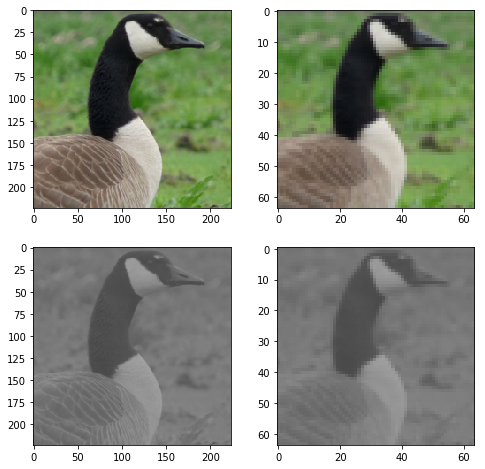

In [562]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
index = 4999
imgs = [val_dataset224[index][0].permute([1,2,0]),
        val_dataset64[index][0].permute([1,2,0]),
        val_dataset224_sat0con04[index][0].permute([1,2,0]),
        val_dataset64_sat0con04[index][0].permute([1,2,0])
       ]
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i-1])
plt.show()

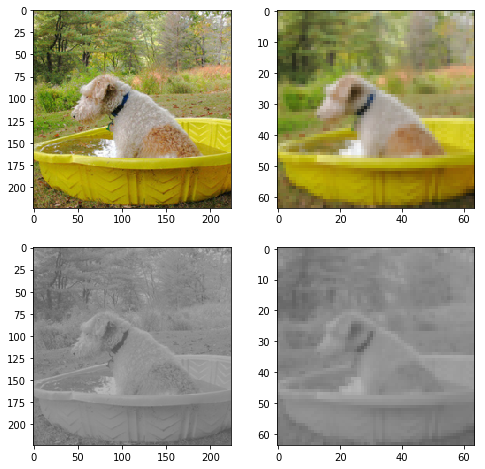

In [572]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
index = 9400
imgs = [val_dataset224[index][0].permute([1,2,0]),
        val_dataset64[index][0].permute([1,2,0]),
        val_dataset224_sat0con04[index][0].permute([1,2,0]),
        val_dataset64_sat0con04[index][0].permute([1,2,0])
       ]
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i-1])
plt.show()

In [ ]:
#From (200 imagenet random)
#163 -> fox vs deer
#470 -> dog vs cat
#810 -> boar vs sheep
#600 -> sheep vs dog
#460 -> dog vs fox
#9988 -> scarf vs snake 

In [624]:
val_dataset64_cbefore = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            ColorVary(1,1,0,0),
            transforms.Resize(int(224*(1+increase_r))),
            transforms.CenterCrop(224),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))
val_dataset64_cafter = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(int(224*(1+increase_r))),
            transforms.CenterCrop(224),
            ColorVary(1,1,0,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

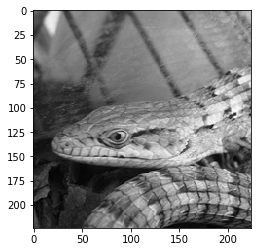

In [625]:
plt.imshow(val_dataset64_cbefore[2220][0].permute([1,2,0]))

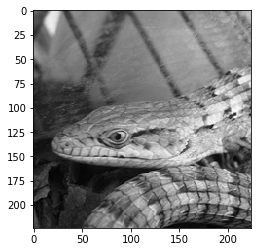

In [626]:
plt.imshow(val_dataset64_cafter[2220][0].permute([1,2,0]))

In [615]:
val_dataset64_cbefore[0][0], val_dataset64_cafter[0][0]

(tensor([[[0.4196, 0.4392, 0.3922,  ..., 0.6588, 0.6471, 0.6588],
          [0.5294, 0.5647, 0.5490,  ..., 0.6157, 0.6039, 0.6549],
          [0.5843, 0.5255, 0.4118,  ..., 0.6118, 0.6078, 0.6039],
          ...,
          [0.5569, 0.5961, 0.6510,  ..., 0.4510, 0.4549, 0.4667],
          [0.5333, 0.5333, 0.6039,  ..., 0.4980, 0.4941, 0.5216],
          [0.5373, 0.5098, 0.5804,  ..., 0.5333, 0.5373, 0.5333]],
 
         [[0.4196, 0.4392, 0.3922,  ..., 0.6588, 0.6471, 0.6588],
          [0.5294, 0.5647, 0.5490,  ..., 0.6157, 0.6039, 0.6549],
          [0.5843, 0.5255, 0.4118,  ..., 0.6118, 0.6078, 0.6039],
          ...,
          [0.5569, 0.5961, 0.6510,  ..., 0.4510, 0.4549, 0.4667],
          [0.5333, 0.5333, 0.6039,  ..., 0.4980, 0.4941, 0.5216],
          [0.5373, 0.5098, 0.5804,  ..., 0.5333, 0.5373, 0.5333]],
 
         [[0.4196, 0.4392, 0.3922,  ..., 0.6588, 0.6471, 0.6588],
          [0.5294, 0.5647, 0.5490,  ..., 0.6157, 0.6039, 0.6549],
          [0.5843, 0.5255, 0.4118,  ...,

In [590]:
increase_r = 32/224
val_dataset224 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(224),
            
            transforms.CenterCrop(224),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64 = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(64),
            
            transforms.CenterCrop(64),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset224_rc = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(int(224*(1+increase_r))),
            
            transforms.RandomCrop(224),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64_rc = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(int(64*(1+increase_r))),
            
            transforms.RandomCrop(64),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))
val_dataset224_cc = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(int(224*(1+increase_r))),
            
            transforms.CenterCrop(224),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))

val_dataset64_cc = datasets.ImageFolder(
        valdir,
        transforms.Compose([
            transforms.Resize(int(64*(1+increase_r))),
            
            transforms.CenterCrop(64),
            ColorVary(1,1,1,0),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
            
        ]))


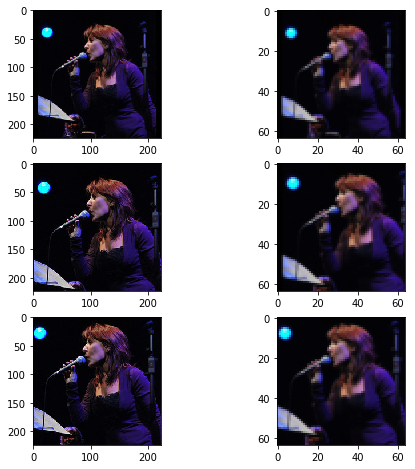

In [599]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 3
index = 20090
imgs = [val_dataset224[index][0].permute([1,2,0]),
        val_dataset64[index][0].permute([1,2,0]),
        val_dataset224_rc[index][0].permute([1,2,0]),
        val_dataset64_rc[index][0].permute([1,2,0]),
        val_dataset224_cc[index][0].permute([1,2,0]),
        val_dataset64_cc[index][0].permute([1,2,0]),
       ]
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i-1])
plt.show()

In [560]:
len(val_dataset)

50000

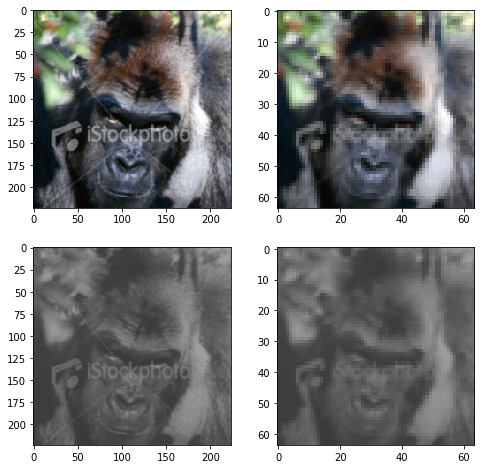

In [543]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
index = 1000
imgs = [val_dataset224[index][0].permute([1,2,0]),
        val_dataset64[index][0].permute([1,2,0]),
        val_dataset224_sat0con04[index][0].permute([1,2,0]),
        val_dataset64_sat0con04[index][0].permute([1,2,0])
       ]
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i-1])
plt.show()

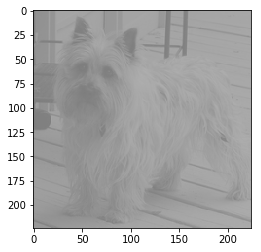

In [408]:
plt.imshow(val_dataset224_nocolor[994][0].permute([1,2,0]))

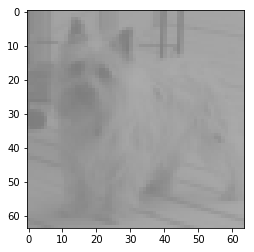

In [409]:
plt.imshow(val_dataset64_nocolor[994][0].permute([1,2,0]))

In [ ]:
plt.imshow(val_dataset224_nocolor[890][0].permute([1,2,0]))

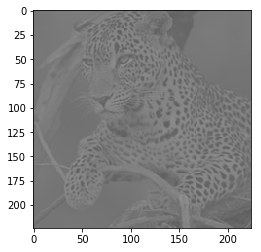

In [410]:
plt.imshow(val_dataset224_nocolor[890][0].permute([1,2,0]))

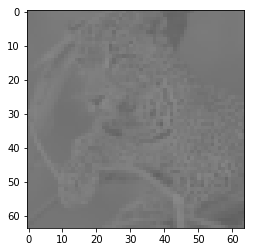

In [411]:
plt.imshow(val_dataset64_nocolor[890][0].permute([1,2,0]))